In [5]:
import requests
import pandas as pd
import numpy as np
import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

%matplotlib inline
pylab.rcParams['figure.figsize'] = (7.0, 10.0)

In [2]:
files = {'f': ('Results.pdf', open('Results.pdf', 'rb'))}
response = requests.post("https://pdftables.com/api?key=d1n7ydhafd5t&format=xlsx-single", files=files)
response.raise_for_status() # ensure we notice bad responses
with open("WCh_ValDiSole_Men.xlsx", "wb") as f:
    f.write(response.content)
    
print("PDF converted to Excel format")

PDF converted to Excel format


In [16]:
def parse_time(raw_time):
    '''Parse the raw time strings into timedeltas for doing arithmetic on the times'''
    if raw_time == '' or None or pd.isnull(raw_time):
        return None
    else:
        try:
            dt = datetime.datetime.strptime(str(raw_time), '%M:%S.%f')
            timedelta = datetime.timedelta(minutes=dt.minute, seconds=dt.second, microseconds=dt.microsecond)
            return timedelta
        except:
            dt = datetime.datetime.strptime(str(raw_time), '%S.%f')
            timedelta = datetime.timedelta(seconds=dt.second, microseconds=dt.microsecond)
            return timedelta


def timedeltaToString(rawTd):
    '''Convert timedelta to a MM:SS.000 formatted string'''
    try:
        dt = str(rawTd)[-12:-3]
        return dt
    except:
        return None

In [44]:
def processResults(df):
    '''Calculate split times, time gaps and rankings for each rider'''
    #Apply the time parser to the raw times
    for i in range(1,4):
        df['split' + str(i)] = df['split' + str(i)].apply(parse_time)

    #Calculate the total sector times for each split
    df['sector1'] = df['split1']
    df['sector2'] = df['split2'] - df['split1']
    df['sector3'] = df['split3'] - df['split2']

    #Calculate the time gaps and rankings for everything
    cols = ['sector1', 'sector2', 'sector3', 'split1', 'split2', 'split3']

    for col in cols:
        df[col + 'Gap'] = df[col].apply(lambda x: (x - df[col].min())/np.timedelta64(1,'s'))
        df[col + 'Rank'] = df[col].rank().astype(int)
        df[col] = df[col].apply(timedeltaToString)
        df[col + 'Rank']

    return df

In [64]:
cols = ['Name','split1','split2','split3']

df = pd.read_excel('WCh_ValDiSole_Men_Munged.xlsx')
df = df[['Name','Split 1', 'Split 2','Time']]
df.columns = cols
df.head()

,Name,split1,split2,split3
0,HART Danny,1:17.587,2:42.415,3:32.484
1,GREENLAND Laurie,1:18.763,2:45.005,3:35.411
2,PAYET Florent,1:20.189,2:48.953,3:37.531
3,BROSNAN Troy,1:20.481,2:48.234,3:38.361
4,KERR Bernard,1:19.993,2:47.108,3:38.573


In [65]:
df = processResults(df)
df.head()

,Name,split1,split2,split3,sector1,sector2,sector3,sector1Gap,sector1Rank,sector2Gap,sector2Rank,sector3Gap,sector3Rank,split1Gap,split1Rank,split2Gap,split2Rank,split3Gap,split3Rank
0,HART Danny,01:17.587,02:42.415,03:32.484,01:17.587,01:24.828,00:50.069,0.000,1,0.000,1,1.491,2,0.000,1,0.000,1,0.000,1
1,GREENLAND Laurie,01:18.763,02:45.005,03:35.411,01:18.763,01:26.242,00:50.406,1.176,2,1.414,3,1.828,4,1.176,2,2.590,2,2.927,2
2,PAYET Florent,01:20.189,02:48.953,03:37.531,01:20.189,01:28.764,00:48.578,2.602,8,3.936,8,0.000,1,2.602,8,6.538,8,5.047,3
3,BROSNAN Troy,01:20.481,02:48.234,03:38.361,01:20.481,01:27.753,00:50.127,2.894,10,2.925,7,1.549,3,2.894,10,5.819,6,5.877,4
4,KERR Bernard,01:19.993,02:47.108,03:38.573,01:19.993,01:27.115,00:51.465,2.406,5,2.287,4,2.887,8,2.406,5,4.693,3,6.089,5


In [66]:
df.to_csv('WCh_ValDiSole_Men.csv')

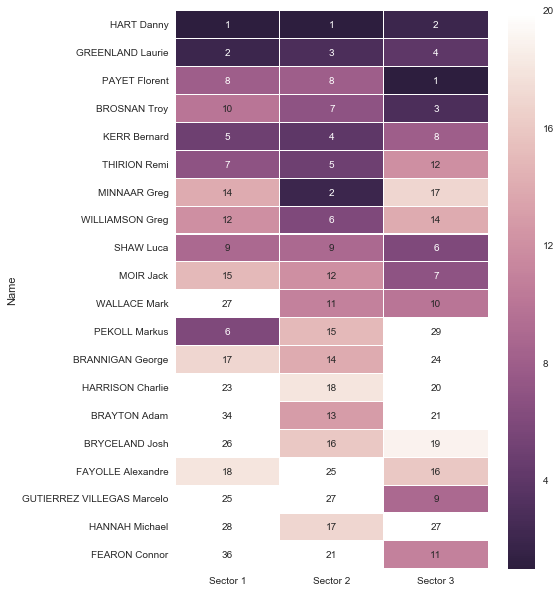

In [67]:
df_heatmap = df[df['split3Rank'] <= 20][['Name', 'split3Rank','sector1Rank', 'sector2Rank', 'sector3Rank']].sort_values('split3Rank')
cols = ['Name', 'Final', 'Sector 1', 'Sector 2', 'Sector 3']
df_heatmap.columns = cols
df_heatmap = df_heatmap[['Name', 'Sector 1', 'Sector 2', 'Sector 3']]
df_heatmap = df_heatmap.set_index('Name')
df_heatmap.head()

cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d", linewidths=.1, vmin=1, vmax=20, cmap=cmap)
heatmap.figure.savefig('valdisole_heatmap.png', bbox_inches='tight')

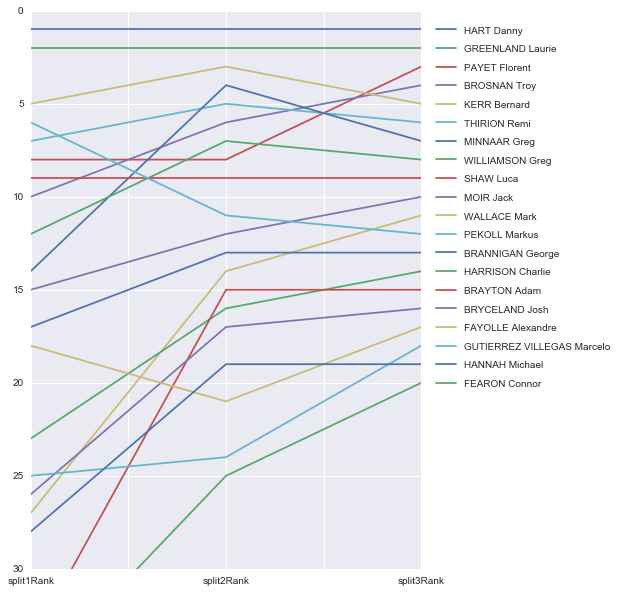

In [68]:
df_splittimes = df[df['split3Rank'] <= 20][['Name', 'split1Rank','split2Rank', 'split3Rank']]
df_splittimes = df_splittimes.set_index('Name')
df_splittimes = df_splittimes.T

sns.set_style("darkgrid")
df_splittimes.plot()
axes = plt.gca()
axes.set_ylim([0,30])
axes.invert_yaxis()
plt.legend(bbox_to_anchor=(1, 1), labelspacing=0.96, borderpad=1.5, loc=2, borderaxespad=0.)
plt.savefig('valdisole_positiontracker.png', bbox_inches='tight')

In [69]:
groups = ['split1', 'split2', 'split3', 'sector2', 'sector3']

for group in groups:
    segment = df[['Name', group + 'Rank', group, group + 'Gap']].sort_values(group + 'Rank', ascending=True)[:20]
    cols = ['Name', 'Position', 'Time', 'Gap']
    segment.columns = cols
    segment.to_json(group + '.json', orient='records')

print("json for d3 plots created successfully!")

json for d3 plots created successfully!
